# Init the libraries

In [ ]:
!pip install gymnasium

In [1]:
# Imports
from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import random
import time
from statistics import mean

import gymnasium as gym
import numpy as np
from gymnasium import spaces
from matplotlib import pyplot as plt

# Grid World environment

In [2]:
# Custom 2D GridWorld Enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}

    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3

    def __init__(self, width, height, reward_type="sparse", obstacles=False, verbose=False):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]                         # Mapping of the actions
        self.num_actions = 4

        self.width = width
        self.height = height
        self.size = width * height                                                  # Size of the grid world
        self.num_states = self.size                                                 # States are computed (width * height)
        self.num_obstacles = int((width + height) /2)                               # Number of obstacles present in our Grid
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8)          # Goal state = Bottom right cell

        self.action_space = spaces.Discrete(4)                                      # Actions space of agent : up, down, left and right
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])    # Observation : Cell indices in the grid

        if obstacles:
            self.num_obstacles = int((width+height)/2)
        else:
            self.num_obstacles = 0

        self.obstacles = np.zeros((height, width))                                  # Initialize the obstacles as a Grid with all zeros

        self.verbose = verbose                                                      # If we want to print out stuff

        self.reward_type = reward_type

        """
        Looping for the number of obstacles, we take a random number between height and width
        and until the two numbers are not (0, 0) -> Because it's the goal, we keep on looping.
        When we've found two suitable numbers, we put 1 in the Obstacles grid at coords height/width.
        """
        for i in range(self.num_obstacles):
            obstacle = random.randrange(height) , random.randrange(width)
            while obstacle == (0, 0):
                obstacle = random.randrange(height), random.randrange(width)
            self.obstacles[obstacle] = 1

        self.num_steps = 0
        self.max_steps = height * width

        self.current_state = np.zeros((2), np.uint8) # Initial state = [0,0]

        self.directions = np.array([
            [-1, 0], # UP
            [0, -1], # LEFT
            [1, 0],  # DOWN
            [0, 1]   # RIGHT
        ])

    def transition_function(self, s, a):
        s_prime =  np.zeros((2), np.uint8)
        s_prime = s + self.directions[a, :]

        # Now we check if the agent is going out of the boundaries.
        #   - If I take state[0], I'm working on the rows.
        #   - If I take state[1], I'm working on the columns.
        if(s_prime[0] < 0 or s_prime[0] >= self.height):
            if(self.verbose):
                print("Agent is going outside of the grid. Staying in the same cell")
            return s
        if(s_prime[1] < 0 or s_prime[1] >= self.width):
            if(self.verbose):
                print("Agent is going outside of the grid. Staying in the same cell")
            return s
        
        # Check obstacles for the agent.
        # If the agent new coordinates are in the coordinates of an obstacle, exit.
        if(self.obstacles[s_prime[0], s_prime[1]] == 1):
            print("Agent is hitting an obstacle. Staying in the same cell")
            return s            
    
        return s_prime # We simply return s_prime

    def reward_function(self,s):
        r = -1 # By default, reward is -1

        if (s == self.end_state).all(): # If agent is in goal state
            if self.reward_type == "sparse":
                r = 100
            else:
                r = 1 / (np.sum((self.end_state - s))+0.000001)

        return r

    def termination_condition(self, s):
        truncated = self.num_steps >= self.max_steps
        terminated = False
        
        if(truncated):
            if(self.verbose):
                print("Maximum steps reached. Exiting.")
            terminated = True
        if(s == self.end_state).all():
            if(self.verbose):
                print("Agent is in the goal state. Let's end the loop.")
            terminated = True

        return terminated, truncated

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        terminated, truncated = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, terminated, truncated, None

    def render(self):
        '''
            render the state
        '''

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height):
            for c in range(self.width):
                if r == row and c == col:
                    print("| A ", end='')
                elif r == self.end_state[0] and c == self.end_state[1]:
                    print("| G ", end='')
                else:
                    if self.obstacles[r,c] == 1:
                        print('|///', end='')
                    else:
                        print('|___', end='')
            print('|')
        print('\n')

    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0

        return self.current_state

    def close(self):
        pass

class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8, reward_type="sparse", obstacles=False, verbose=False):
        super(NonDeterministicGridWorld, self).__init__(width, height, reward_type, obstacles)
        self.probability_right_action = p
        self.verbose = verbose

    def transition_function(self, s, a):
        if(self.verbose):
            print("Original action to perform:", self.ACTION_NAMES[a])
        s_prime = s + self.directions[a, :]

        # With probability 1 - p, we have a diagonal movement
        # random.random() returns a number between 0 and 1
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                if(self.verbose):
                    print(F"Actual action performed: {self.ACTION_NAMES[a]} + {self.ACTION_NAMES[(a+1) % self.num_actions]}")
                s_prime = s_prime + self.directions[(a+1) % self.num_actions, :]
            else:
                if(self.verbose):
                    print(F"Actual action performed: {self.ACTION_NAMES[a]} + {self.ACTION_NAMES[(a-1) % self.num_actions]}")
                s_prime = s_prime + self.directions[(a-1) % self.num_actions, :]

        # Check if the agent goes out of the grid along with obstacles
        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


# Q-learning

## Q-Table evaluation

In [3]:
def evaluateQTable(env, q_table, n_episodes=10, render=False):
    cum_rews = []                                                           # Accumulated rewards for episodes
    for ep in range(n_episodes):                                            # Loop throughout the episodes
        if render:
            print(F"# --------- Episode n.{ep+1} --------- # ")
        cum_rew = 0                                                         # Accumulate reward until we reach the goal 
        done = False
        state = env.reset()
        while not done:
            action = np.argmax(q_table[state[0], state[1]])                 # Take directly argmax from the Q-Table. Meaning, we exploit the learned values
            state, reward, terminated, truncated, info = env.step(action)   # Run a simulation step in the environment with the best action
            done = terminated or truncated
            if render:
                print(F"Action taken: {env.ACTION_NAMES[action]}")
                env.render()
                print(F"Termination reached: {done}")
            cum_rew += reward                                               # Accumulate all the rewards until we reach the goal
        cum_rews.append(cum_rew)                                            # Insert the accumulated rewards for this episode.
    mean_rew = mean(cum_rews)                                               # Insert the mean reward we got from running n episodes.
    if render:
        print("Mean reward obtained in {} episodes: {} ".format(n_episodes, mean_rew))
    return mean_rew

## Actual Q-Learning algorithm

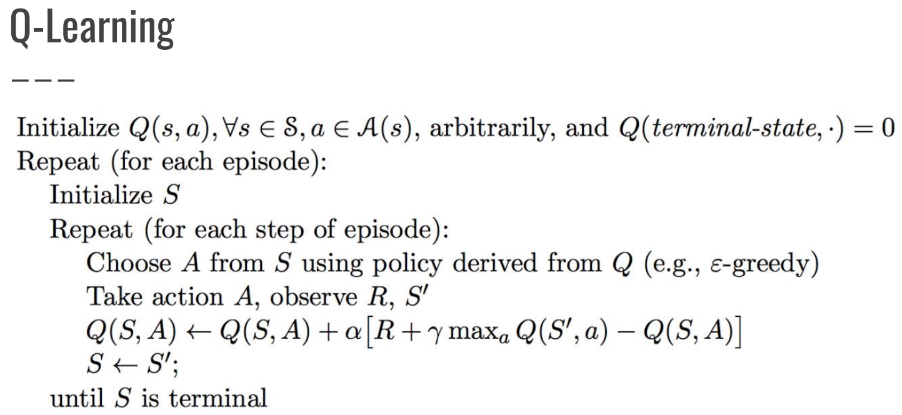

In [5]:
def qLearning(env, alpha=1.0, gamma=0.99, initial_epsilon=1.0, n_episodes=10000):

    """ 
    -------- HYPERPARAMETERS --------
        - alpha = Learning Rate
        - gamma = Discount factor
        - initial_epsilon = Initial Epsilon value
        - n_episodes = Total number of episodes
    ------------------------ --------
    """

    # We start by defining the dimensions of the Q-Table
    #
    # Basically what we do here is that we take the state space dimensions (5x5) through
    # env.observation_space.nvec and we append it to this list "q_table_size".
    # Then, we do the same for the action_space (4).
    #
    # In the end, we will have a list with [5, 5, 4], which we'll use to initialize our Q-Table.
    q_table_size = []
    for size in env.observation_space.nvec: # 5 x 5
        q_table_size.append(size)
    q_table_size.append(env.action_space.n) # 4

    print("Q-Table size: ", q_table_size) # [5, 5, 4]

    # Initialize Q-Table as a [5, 5, 4] Numpy array.
    # This means that we will have a 5 x 5 array for each single action.
    q_table = np.zeros(q_table_size) 

    # Initialize some variables (Epsilon, rewards, etc)
    epsilon = initial_epsilon # Init epsilon
    received_first_reward = False
    evaluation_rewards = [] # Evaluation
    mean_evaluation_rewards = [] # Mean Evaluation
    window = 100

    env.verbose = False # Silence the prints about agent diagonal actions, etc.

    # For all the episodes
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        while not done: # "until S is terminal"
            # Choose the action with epsilon-greedy strategy
            # We can use random.random() to generate a random number between 0 and 1
            # Let's remember that with 1-ϵ we choose the argmax of Q, otherwise 
            # we'll choose a random action from the action space.
            action = ... # TODO

            # Run a simulation step in the environment with the chosen action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            #env.render()

            # Update the Q-Table using the transition
            q_table[...] = ... # TODO

            if not received_first_reward and reward > 0:
                received_first_reward = True
                print("Received first reward at episode ", ep)

            state = next_state # S <- S'

        # Update current epsilon only if we received the first reward
        if received_first_reward:
            epsilon = 0.9999 * epsilon

        # Evaluate the Q-Table and place it in the evaluation_rewards list
        evaluation_rewards.append(evaluateQTable(env, q_table, n_episodes=5)) # Mean reward with this Q-Table over 5 episodes
        mean_evaluation_rewards.append(mean(evaluation_rewards[-window:]))      # [-window:] = We take the [-100:end] array. Basically all the 100 values

    plt.title("Mean Evaluation Rewards")
    plt.xlabel('Episode')
    plt.ylabel('Mean reward')
    plt.grid(True)
    plt.plot(mean_evaluation_rewards)

    print("Training finished in {} episodes\n".format(n_episodes))
    return q_table

# Run a test

First, we will run a random exploration of the agent. <br>
In the second part, we will run the Q-Learning algorithm on the same environment.

In [6]:
# Define the 2D Environment
# N.B: This environment has been built with probability 0.2 (1 - p) to do a diagonal movement!
env = NonDeterministicGridWorld(width=5, height=5, p=0.8, reward_type="sparse", obstacles=False, verbose=True)
state = env.reset()
env.render()

| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |




### Random Exploration

In [7]:
# Random exploration
done = False
env.reset()
while not done:
            action = env.action_space.sample() # Take a random action from the action space.
                                               # Could be either 0, 1, 2 or 3.

            print(F"Random action taken: {env.ACTION_NAMES[action]}")
            
            # Now, let's simulate this action in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            print(F"Termination reached: {done}")
            print(F"Reward: {reward}")
            env.render()

Random action taken: LEFT
Original action to perform: LEFT
Termination reached: False
Reward: -1
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Random action taken: LEFT
Original action to perform: LEFT
Termination reached: False
Reward: -1
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Random action taken: LEFT
Original action to perform: LEFT
Termination reached: False
Reward: -1
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Random action taken: RIGHT
Original action to perform: RIGHT
Termination reached: False
Reward: -1
|___| A |___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Random action taken: RIGHT
Original action to perform: RIGHT
Actual action performed: RIGHT + DOWN
Termination reached: False
Reward: -1
|___|___|___|___|___|
|__

### Q-Learning applied on the same environment

Q-Table size:  [5, 5, 4]
Received first reward at episode  15
Training finished in 100 episodes



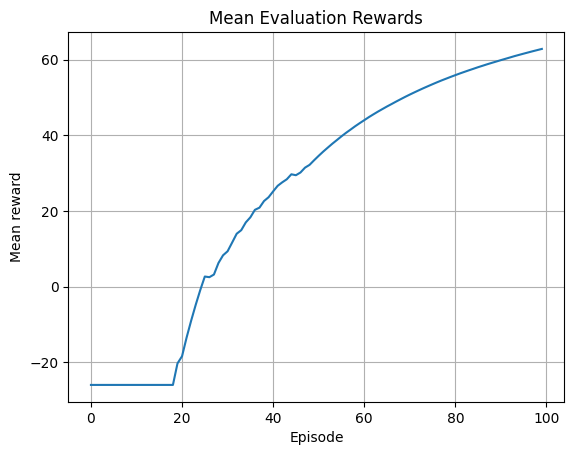

In [12]:
# Q-learning
qTable = qLearning(env, alpha=0.2, initial_epsilon=0.8, n_episodes=100)

In [13]:
# Print Q values
for action in range(env.action_space.n): # For all actions in the action space (4)
    print(F"Q(s, a = {action}) | Action {env.ACTION_NAMES[action]}")
    print(qTable[:, :, action])

Q(s, a = 0) | Action UP
[[22.18376424 26.22010599 27.14582577 13.65762045  5.13959938]
 [18.44816688 22.49208346 27.63997355 15.3579332   1.09443248]
 [ 3.73665244 16.18334958 35.91723311 19.83115622  1.82874384]
 [11.33359062 36.66415004 51.0179391  21.49254011  8.31720656]
 [18.45511415 24.16421579 57.44920692 61.7782438   0.        ]]
Q(s, a = 1) | Action LEFT
[[25.28544265 25.49627036 24.61741752 26.5237396  18.42623323]
 [ 2.87971398 16.45983315 26.03099034 30.94357902  9.10948548]
 [ 9.79601379 10.37054957 42.68626504 32.67308192 25.39513545]
 [15.29119158 17.65052346 37.64917828 40.74266333 46.92025016]
 [12.06063916 20.18753231 34.44648987 74.57852203  0.        ]]
Q(s, a = 2) | Action DOWN
[[22.03276243 26.66229782 39.41855667 30.35983051  8.7064679 ]
 [12.32844483 29.16248131 50.28992937 33.31923233 13.00941406]
 [31.14750374 39.1283732  64.4718333  65.85899335  7.28997894]
 [14.60196771 43.09699033 80.88315052 90.79700969 19.02717958]
 [ 5.35798167 31.49471797 72.12560565 74

## Evaluate policy

Render the Agent behaviour

In [14]:
mean_cum_rew = evaluateQTable(env, qTable, render=True)

# --------- Episode n.1 --------- # 
Action taken: RIGHT
|___| A |___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___| A |___| G |


Termination reached: False
Action taken: